In [1]:
import random
import torch
import evaluate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import re
import networkx as nx
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
random.seed(111)

### Preprocessing

In [3]:
def rem_ascii(s):
    return "".join([c for c in s if ord(c) < 128 ])

In [4]:
def clean(text):
    # normalize characters
    text = text.lower()
    text = text.replace('\n', ' ')
    text = text.replace(' . ', '')
    # remove punctuation, non-ascii characters, and other patterns
    text = re.sub("[^a-zA-Z .]", "", text)

    text = re.sub("(__+)", ' ', str(text)).lower()  # remove _ if it occors more than one time consecutively
    text = re.sub("(--+)", ' ', str(text)).lower()  # remove - if it occors more than one time consecutively
    text = re.sub("(~~+)", ' ', str(text)).lower()  # remove ~ if it occors more than one time consecutively
    text = re.sub("(\+\++)", ' ', str(text)).lower()  # remove + if it occors more than one time consecutively
    text = re.sub("(\.\.+)", ' ', str(text)).lower()  # remove . if it occors more than one time consecutively


    # remove stopwords
    stop = stopwords.words('english')
    text = " ".join([word for word in text.split() if word not in (stop)])

    return text.strip()

### Bert Embedding

In [5]:
#nltk.download('punkt')  # one time execution
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\epaul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
df = pd.read_csv('Data/papers.csv')
df = df[df['abstract'] != 'Abstract Missing'].reset_index()
#df = df[df['paper_text'].str.len() < 1000].reset_index()

In [7]:
df['paper_text'] = df['paper_text'].apply(clean)

In [8]:
df = df[df['paper_text'].str.len() < 25000].reset_index()
rand = random.randint(0, len(df))

In [26]:
single = df.loc[rand, 'paper_text']

In [27]:
sentences = sent_tokenize(single)
cleaned_texts = [rem_ascii(clean(sentence)) for sentence in sentences]

In [28]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [29]:
encoding = tokenizer.batch_encode_plus(
    cleaned_texts,                    # List of input texts
    padding=True,              # Pad to the maximum sequence length
    truncation=True,           # Truncate to the maximum sequence length if necessary
    return_tensors='pt',      # Return PyTorch tensors
    add_special_tokens=True    # Add special tokens CLS and SEP
)
 
input_ids = encoding['input_ids']  # Token IDs
attention_mask = encoding['attention_mask']  # Attention mask

In [30]:
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    word_embeddings = outputs.last_hidden_state  # This contains the embeddings

In [31]:
sentence_embedding = word_embeddings.mean(dim=1)  # Average pooling along the sequence length dimension

sentence_embedding.shape

torch.Size([308, 768])

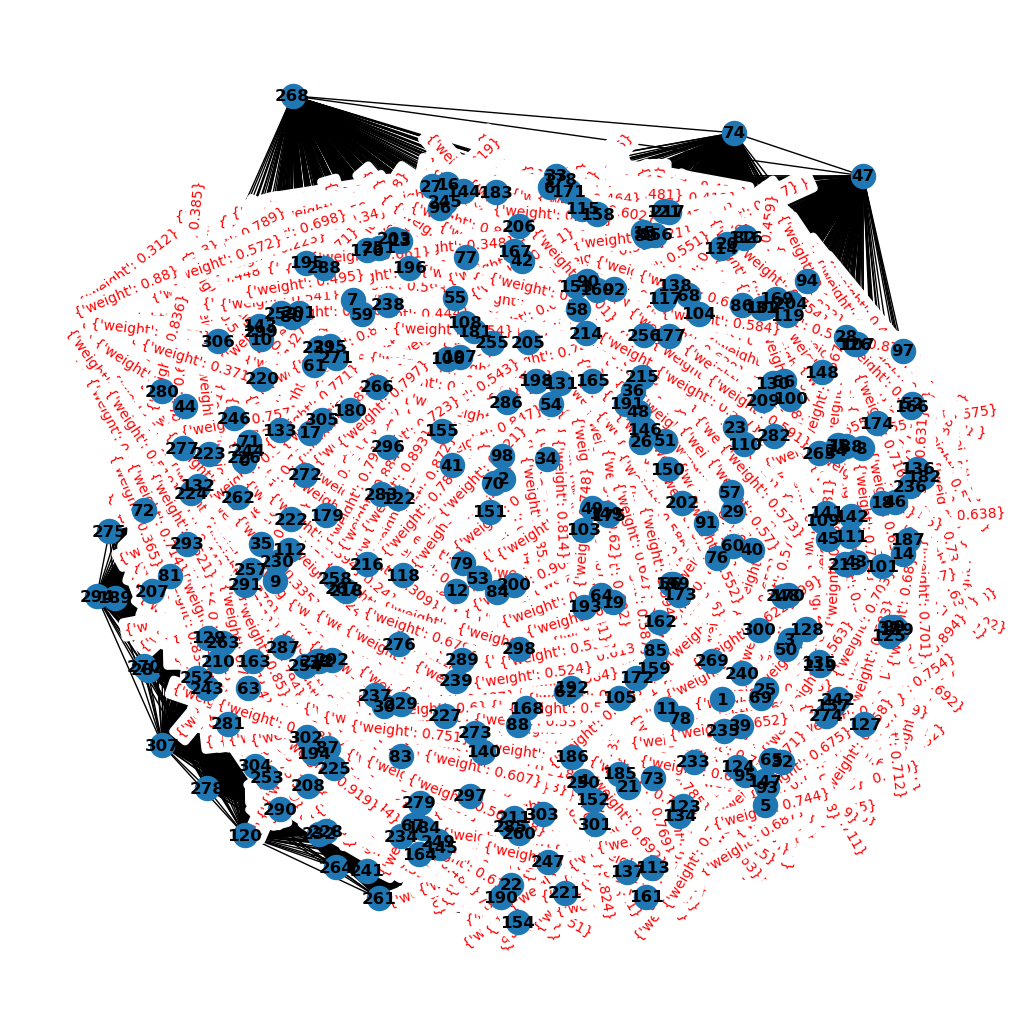

In [32]:
dim = 768
sim_mat = np.zeros([len(cleaned_texts), len(cleaned_texts)])
for i in range(len(cleaned_texts)):
    for j in range(len(cleaned_texts)):
        if i != j:
            sim_mat[i][j] = cosine_similarity(sentence_embedding[i].reshape(1,dim),sentence_embedding[j].reshape(1,dim))[0,0]
            
sim_mat = np.round(sim_mat,3)

# Creating the network graph
nx_graph = nx.from_numpy_array(sim_mat)
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(nx_graph)
nx.draw(nx_graph, with_labels=True, font_weight='bold')
nx.draw_networkx_edge_labels(nx_graph,pos,font_color='red')
plt.show()


In [33]:
scores = nx.pagerank(nx_graph)

In [34]:
ranked_sentences = sorted(((scores[i],i) for i,s in enumerate(sentences)), reverse=True)
arranged_sentences = sorted(ranked_sentences[0:6], key=lambda x:x[1])
pred = [" ".join([sentences[x[1]] for x in arranged_sentences])]

In [35]:
rouge = evaluate.load('rouge')

In [36]:
results = rouge.compute(predictions=[clean(pred[0])], references=[clean(df.loc[rand, 'abstract'])])
print(results)

{'rouge1': 0.3548387096774194, 'rouge2': 0.21739130434782608, 'rougeL': 0.1935483870967742, 'rougeLsum': 0.1935483870967742}


In [37]:
print(pred)

['robbinsmonro algorithm well simple modification iterates averaged a.k.a. robbinsmonro algorithm well simple modification iterates averaged a.k.a. context machine learning leastsquares logistic regression assumption h satisfied soon kk used additional regularizer. figure plot loglog scale average f n f replications stochastic approximation problem i.i.d. conclusion paper provided nonasymptotic analysis stochastic gradient well averaged version various learning rate sequences form n cn see summary results table . following earlier work optimization machine learning stochastic approximation literatures analysis highlights robust choice c actual difficulty problem strongly convex not.']


In [38]:
df.loc[rand, 'abstract']

'We consider the minimization of a convex objective function defined on a Hilbert space, which is only available through unbiased estimates of  its gradients.  This problem includes  standard machine learning algorithms such as kernel logistic regression and least-squares regression, and is commonly referred to as a stochastic approximation problem in the operations research community. We provide a non-asymptotic analysis of the  convergence of two well-known algorithms, stochastic gradient descent (a.k.a.~Robbins-Monro algorithm) as well as a simple modification where iterates are averaged (a.k.a.~Polyak-Ruppert averaging). Our analysis suggests that a learning rate proportional to the inverse of the number of iterations, while leading to the optimal convergence rate in the strongly convex case, is not robust to the lack of strong convexity or the setting of the proportionality constant. This situation is remedied when using slower decays together with averaging, robustly leading to t

### Full Dataset (TAKES A LONG TIME)

In [20]:
score = 0
max_score = 0
p_id = 0
dim = 768
for paper in range(250):
    sentences = sent_tokenize(df.loc[paper, 'paper_text'])
    cleaned_texts = [rem_ascii(clean(sentence)) for sentence in sentences]


    encoding = tokenizer.batch_encode_plus(
        cleaned_texts,                    # List of input texts
        padding=True,              # Pad to the maximum sequence length
        truncation=True,           # Truncate to the maximum sequence length if necessary
        return_tensors='pt',      # Return PyTorch tensors
        add_special_tokens=True    # Add special tokens CLS and SEP
        )

    input_ids = encoding['input_ids']  # Token IDs

    attention_mask = encoding['attention_mask']  # Attention mask

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        word_embeddings = outputs.last_hidden_state  # This contains the embeddings
    
    sentence_embedding = word_embeddings.mean(dim=1)  # Average pooling along the sequence length dimension
    
    sim_mat = np.zeros([len(cleaned_texts), len(cleaned_texts)])
    for i in range(len(sentences)):
        for j in range(len(sentences)):
            if i != j:
                sim_mat[i][j] = cosine_similarity(sentence_embedding[i].reshape(1,dim),sentence_embedding[j].reshape(1,dim))[0,0]
            
    sim_mat = np.round(sim_mat,3)

    # Creating the network graph
    nx_graph = nx.from_numpy_array(sim_mat)
    scores = nx.pagerank(nx_graph, max_iter=1000)
    ranked_sentences = sorted(((scores[i],i) for i,s in enumerate(sentences)), reverse=True)
    arranged_sentences = sorted(ranked_sentences[0:6], key=lambda x:x[1])
    pred = [" ".join([sentences[x[1]] for x in arranged_sentences])]
    score += rouge.compute(predictions=[clean(pred[0])], references=[clean(df.loc[paper, 'abstract'])])['rouge1']
    if score >= max_score:
        ma_score = score
        p_id = paper
    print(paper)
print(f'avg rouge1 score for Bert embedding is {score/len(df)}')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
avg rouge1 score for Bert embedding is 0.017806549725390818


In [24]:
pred

['introduction consider problem modeling correlated outputs single gaussian process gp. one neat approach account nontrivial correlations outputs employs convolution processes cp. written using matrix notation kf f ikuu i. computational speed informative vector machine ivm employed . nystrom approximation applied kx x . sparse approximations used fixed inducing points equally spaced range input r . selected one sensors signals tide height applied pitc approximation scheme additional squared exponential independent kernel wq x .']

['sparse convolved gaussian processes multioutput regression neil d. lawrence school computer science university manchester u.k. neillcs.man.ac.uk mauricio alvarez school computer science university manchester u.k. alvarezmcs.man.ac.uk abstract present sparse approximation approach dependent output gaussian processes gp.',
 'employing latent function framework apply convolution process formalism establish dependencies output variables latent function represented gp.',
 'based latent functions establish approximation scheme using conditional independence assumption output processes leading approximation full covariance determined locations latent functions evaluated.',
 'show results proposed methodology synthetic data real world applications pollution prediction sensor network.',
 'introduction consider problem modeling correlated outputs single gaussian process gp.',
 'applications modeling multiple outputs include multitask learning see e.g.',
 'jointly predicting concentration diffe